In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["font.family"] = "fantasy"
import numpy as np
import random
import scipy
import scipy.misc
import scipy.cluster

from pandas.io.json import json_normalize
import plotly.express as px
import plotly.graph_objects as pgo
import plotly.offline as pol

%load_ext Cython


In [2]:
states_and_their_abbreviations = {
        "UNITED STATES": "USA",
        "ALABAMA": "AL",
        "ALASKA": "AK",
        "ARIZONA": "AZ",
        "ARKANSAS": "AR",
        "CALIFORNIA": "CA",
        "COLORADO": "CO",
        "CONNECTICUT": "CT",
        "DELAWARE": "DE",
        "DISTRICT OF COLUMBIA": "DC",
        "D.C." :"DC",
        "FLORIDA": "FL",
        "GEORGIA": "GA",
        "GU": "Guam",
        "HAWAII": "HI",
        "IDAHO": "ID",
        "ILLINOIS": "IL",
        "INDIANA": "IN",
        "IOWA": "IA",
        "KANSAS": "KS",
        "KENTUCKY": "KY",
        "LOUISIANA": "LA",
        "MAINE": "ME",
        "MARYLAND": "MD",
        "MASSACHUSETTS": "MA",
        "MICHIGAN": "MI",
        "MINNESOTA": "MN",
        "MISSISSIPPI": "MS",
        "MISSOURI": "MO",
        "MONTANA": "MT",
        "NEBRASKA": "NE",
        "NEVADA": "NV",
        "NEW HAMPSHIRE": "NH",
        "NEW JERSEY": "NJ",
        "NEW MEXICO": "NM",
        "NEW YORK": "NY",
        "NORTH CAROLINA": "NC",
        "NORTH DAKOTA": "ND",
        "OHIO": "OH",
        "OKLAHOMA": "OK",
        "OREGON": "OR",
        "PENNSYLVANIA": "PA",
        "RHODE ISLAND": "RI",
        "SOUTH CAROLINA": "SC",
        "SOUTH DAKOTA": "SD",
        "TENNESSEE": "TN",
        "TEXAS": "TX",
        "UTAH": "UT",
        "VERMONT": "VT",
        "VIRGINIA": "VA",
        "WASHINGTON": "WA",
        "WEST VIRGINIA": "WV",
        "WISCONSIN": "WI",
        "WYOMING": "WY",
        "YEARS" :"Years"}

In [3]:
%%cython --annotate

def get_state(x: str):
    return x.split(',')[1]


In [4]:
%%cython --annotate

def get_percs_to_be_dropped(percs_to_be_dropped, start_year, end_year):
    cdef int thing
    cdef int end_yr = end_year
    cdef int start_yr = start_year
    thing = end_yr - start_yr + 1
    for i in range(thing):
        percs_to_be_dropped.append(str(start_year + i) + '_(%)')
    
    return percs_to_be_dropped

In [5]:
def read_unemployment_by_year(start_year: int, end_year: int, show_plot: bool) -> pd.DataFrame:
    """
    :param start_year: The first year of the dataframe read in from the Unemployment Data 'Un.xlsx'. No data exists before year 2008, so this number should be 2008 at minimum.
    :param end_year: The last year of the dataframe read in from the Unemployment Data 'Un.xlsx'. No data exists beyond year 2018, so this number should be 2018 at maximum.
    :param show_plot: Whether the line plot will be created.
    :return: State_total_percentages_only_flipped. This is a pandas dataframe containing only total unemployment percentages in all states.
    """

    #TODO: This function has a bug. Whenever the start_year is not 2008, data in the second year followed by every +3 year gets out of whack
    #TODO: I believe this has something to do with "State_total.iloc[0:,3*i+2] / State_total.iloc[0:,3*i]*100". Whoever wrote the original will have to fix this.
    #TODO: For now, please ONLY state start_year as 2008.

    if start_year < 2008 or end_year > 2018 or end_year < start_year:
        print("Botched year formats!! Check input values!")
        return None

    df = pd.read_excel('Un.xlsx')
    # Data Cleaning
    df['State'] = df['State Abb.'].map(lambda x: get_state(x))
    df.set_index('State', drop=True, append=False, inplace=True, verify_integrity=False)
    State_total = df.groupby('State').sum()
    percs_to_be_dropped = []

#     thing = end_year - start_year + 1

#     for i in range(thing):
#         percs_to_be_dropped.append(str(start_year + i) + '_(%)')
        
    percs_to_be_dropped = get_percs_to_be_dropped(percs_to_be_dropped, start_year, end_year)
    # percs_to_be_dropped = ['2008_(%)', '2009_(%)', '2010_(%)', '2011_(%)', etc.]
    State_total.drop(percs_to_be_dropped, axis=1, inplace=True)
    State_total.drop(['Code'], axis=1, inplace=True)

    # Find State_total['20XX_Percentage'] = State_total["20XX_Unemployed"] / State_total["20XX_Labor"]*100
    for i in range(end_year - start_year + 1):
        State_total[f'{start_year + i}'] = (State_total.iloc[0:, 3 * i + 2] / State_total.iloc[0:, 3 * i]) * 100
    State_total_percentages_only = State_total.iloc[0:, -(end_year - start_year + 1):]
    # The same table, but flipped around
    State_total_percentages_only_flipped = State_total_percentages_only.transpose()
    State_total_percentages_only_flipped = State_total_percentages_only_flipped.rename({'State': 'Years'}, axis=1)
    State_total_percentages_only_flipped.index.names = ['Years']

    if show_plot:
        State_total_percentages_only_flipped.plot(figsize=(32, 18))
        plt.title("Unemployment Rate by State", fontsize=23)
        plt.xlabel('Year', fontsize='xx-large')
        plt.xticks(size=20)
        plt.ylabel('Unemployment Rate', fontsize='xx-large')
        plt.show()

    unemployment_perc_mergeable = State_total_percentages_only_flipped.reset_index().astype({'Years': 'int32'})
    unemployment_perc_mergeable.columns = unemployment_perc_mergeable.columns.str.replace(' ', '')

    return unemployment_perc_mergeable

In [6]:
def read_health_care_coverage_by_year(start_year: int, end_year: int, coverage_type: str, show_plot: bool) -> pd.DataFrame:
    # This function is made for the HIC-4. Health Insurance Coverage Status and Type of Coverage by State--All Persons files
    # It should work on similar files as long as they are also downloaded from: https://www.census.gov/library/publications/2019/demo/p60-267.html
    """
    :param start_year: The first year where the output dataframe will have. Should be 2008 minimum.
    :param end_year: The last year where the output dataframe will have. Should be 2018 maximum.
    :param coverage_type: A string which allows the user to choose which type of insurance coverage to query for. Available options are as follow:
        ['Total', 'Any coverage', 'Uninsured', 'Private', '..Employer-based', '..Direct-purchase', '..TRICARE', 'Public', '..Medicaid', '..Medicare', '..VA Care']
    :param show_plot: Whether the line plot will be created.
    :return: A dataframe which describes the insurance type's coverage in all states.
    """
    if start_year < 2008 or end_year > 2018 or end_year < start_year:
        print("Botched year formats!! Check input values!")
        return None

    hc_converage = pd.read_excel('hic04_acs.xls', skiprows=[0, 1, 2]).dropna(thresh=2)
    years = list(range(end_year, start_year-1, -1))

    each_year_sub = ['Estimate_number', 'Margin_of_Error_number', 'Percentage', 'Margin_of_Error_percentage']
    headers_for_hc_coverage_census = ['Nation/State', 'Coverage Type']

    for each in years:
        for each_sub in each_year_sub:
            headers_for_hc_coverage_census.append(str(each) + '_' + each_sub)

    # Subset the dataframe according to speicified year range, then assign headers to the subset
    hc_converage = hc_converage.iloc[:, 0: len(headers_for_hc_coverage_census)]
    hc_converage.columns = headers_for_hc_coverage_census
    hc_converage = hc_converage[hc_converage['Coverage Type'].notna()].ffill(axis=0)

    iloc_column_num_list = [0, 1]
    for i in range(end_year - start_year + 1):
        iloc_column_num_list.append((i+1)*4)

    # The original Excel file is
    hc_converage_estimate_percentages_only = hc_converage.iloc[0:, iloc_column_num_list]

    # Inspect only the "Uninsured" percentage, including a nationwide one
    hc_uninsured_perc = hc_converage_estimate_percentages_only[
        hc_converage_estimate_percentages_only['Coverage Type'] == coverage_type]

    casting_dict = {}
    for i in range(end_year, start_year - 1, -1):
        casting_dict.update({str(i) + '_Percentage': 'float64'})

    hc_uninsured_perc = hc_uninsured_perc.drop(['Coverage Type'], axis=1).reset_index().drop(['index'], axis=1).replace(
        "N", np.nan).bfill(axis=1).astype(casting_dict)

    hc_uninsured_perc_flipped = hc_uninsured_perc.transpose().reset_index()
    hc_uninsured_perc_flipped.columns = hc_uninsured_perc_flipped.iloc[0]
    hc_uninsured_perc_flipped = hc_uninsured_perc_flipped.rename({'Nation/State': 'Years'}, axis=1)
    hc_uninsured_perc_flipped = hc_uninsured_perc_flipped[1:].iloc[::-1].reset_index().drop(['index'], axis=1)
    hc_uninsured_perc_flipped['Years'] = hc_uninsured_perc_flipped['Years'].str.rstrip('egatnecreP_').astype(
        {'Years': 'int'})
    if show_plot:
        plt.figure(figsize=(24, 13))
        plt.plot('Years', 'UNITED STATES', data=hc_uninsured_perc_flipped, marker='*', color='#4832a8', linewidth=5)
        for each_state in hc_uninsured_perc_flipped.columns[2:]:
            plt.plot('Years', each_state, data=hc_uninsured_perc_flipped, marker='p', markersize=2,
                     color=(random.random(), random.random(), random.random()), linewidth=1)
        plt.legend()
        plt.xlabel('Years', fontsize='xx-large')
        plt.xticks(size=20)
        plt.ylabel('Percentage of People: ' + coverage_type, fontsize='xx-large')
        plt.show()

    # Also converting all state names to their abbreviated forms for convenience
    # Conversion standard referenced from: https://gist.github.com/mshafrir/2646763
    hc_uninsured_perc_mergeable = hc_uninsured_perc_flipped.rename(columns=states_and_their_abbreviations)
    # Converts rates into float64 so correlations can be drawn
    for each in hc_uninsured_perc_mergeable.columns:
        if hc_uninsured_perc_mergeable[each].dtype == 'object':
            hc_uninsured_perc_mergeable = hc_uninsured_perc_mergeable.astype({each: 'float64'})

    # hc_uninsured_perc_mergeable = hc_uninsured_perc_mergeable.drop(['USA'], axis=1)
    return hc_uninsured_perc_mergeable

In [7]:
def read_household_income_by_year(start_year: int, end_year: int, show_plot: bool) -> pd.DataFrame:
    """
    :param start_year: The first year where the output dataframe will have. Should be 1984 minimum.
    :param end_year: The last year where the output dataframe will have. Should be 2018 maximum.
    :param show_plot: Whether a plot will be created.
    :return: A dataframe recording household income in USD within each state, subsetted by the year range specified.
    """
    if start_year < 1984 or end_year > 2018 or end_year < start_year:
        print("Botched year formats!! Check input values!")
        return None

    df = pd.read_excel('Household Income.xls')
    df_flipped = df.transpose().reset_index()
    df_flipped.columns = df_flipped.iloc[0]
    df_flipped = df_flipped.rename({'States': 'Years'}, axis=1)
    df_flipped = df_flipped[1:].iloc[::-1].reset_index().drop(['index'], axis=1)
    df_flipped = df_flipped.astype({"Years": 'int32'})
    # Note to self: For Pandas, the "AND" condition is denoted by "&" not "and"
    df_flipped = df_flipped.loc[(df_flipped['Years'] >= start_year) & (df_flipped['Years'] <= end_year)]
    # For some reason, this dataframe's Years are sorted in descending order. It does not impede merging with other frames, but an ascending sort is left here just in case.
    # df_flipped = df_flipped.sort_values(by='Years', ascending=True)

    if show_plot:
        # Plotting
        plt.figure(figsize=(24, 13))
        plt.plot('Years', 'United States', data=df_flipped, marker='*', color='#4832a8', linewidth=5)
        for each_state in df_flipped.columns[2:]:
            plt.plot('Years', each_state, data=df_flipped, marker='p', markersize=2,
                     color=(random.random(), random.random(), random.random()), linewidth=1)
        plt.legend()
        plt.title("Household Income (USD) by State and Years", fontsize=23)
        plt.xlabel('Years', fontsize='xx-large')
        plt.xticks(size=20)
        plt.ylabel('Household Income (USD)', fontsize='xx-large')
        plt.show()

    # Transforming the dataframe column names to adhere to the same format as other methods
    df_flipped.columns = df_flipped.columns.str.upper()
    df_flipped = df_flipped.rename(columns=states_and_their_abbreviations)

    # Type casting to make the dataframe returned more mergeable with others
    for each in df_flipped.columns:
        if df_flipped[each].dtype == 'object':
            df_flipped = df_flipped.astype({each: 'float64'})

    return df_flipped


In [8]:

def read_household_income_by_year_ver2(start_year: int, end_year: int) -> pd.DataFrame:
    """
    :param start_year: The first year where the output dataframe will have. Should be 1984 minimum.
    :param end_year: The last year where the output dataframe will have. Should be 2018 maximum.
    :return: A dataframe recording household income in USD within each state, subsetted by the year range specified.
    """
    #TODO: Add a plotting feature to this function.

    if start_year < 1984 or end_year > 2018 or end_year < start_year:
        print("Botched year formats!! Check input values!")
        return None

    raw_hh_income_by_state = pd.read_excel('h08.xls')

    start_row_index = 0
    end_row_index = 0
    max_year = 0
    for i in range(len(raw_hh_income_by_state)):
        if raw_hh_income_by_state.iloc[i, 0] == 'CURRENT DOLLARS':
            start_row_index = i + 1
            max_year = int(raw_hh_income_by_state.iloc[i + 1, 1])
        if raw_hh_income_by_state.iloc[i, 0] == str(max_year) + ' DOLLARS':
            end_row_index = i - 1

    skiprow_list = list(range(start_row_index + 1))
    nrow_number = end_row_index - (start_row_index + 1)

    hh_income_by_state = pd.read_excel('h08.xls', skiprows=skiprow_list, nrows=nrow_number + 1)

    hh_header = list(hh_income_by_state.columns)
    hh_first_row = list(hh_income_by_state.iloc[0, :])
    for i in range(len(hh_header)):
        if hh_header[i] == 'State':
            hh_header[i] = hh_header[i]
        else:
            if 'Unnamed' in str(hh_header[i]):
                hh_header[i] = old_header_value
            else:
                old_header_value = hh_header[i]

            hh_header[i] = str(hh_header[i]) + ' ' + str(hh_first_row[i]).replace('\n', ' ')

    hh_income_by_state.columns = hh_header
    hh_income_by_state = hh_income_by_state.drop(hh_income_by_state.index[0])

    # hh_header

    drop_list = []
    for i in hh_header:
        if 'Standard error' in i:
            drop_list.append(i)

    hh_income_by_state = hh_income_by_state.drop(columns=drop_list)
    hh_income_by_state.columns = hh_income_by_state.columns.str.replace(' Median income', '')

    hh_header = list(hh_income_by_state.columns)
    year_revised_dict = {}
    for i in hh_header:
        if '(' in i:
            if str(i)[0:4] in year_revised_dict:
                if year_revised_dict[str(i)[0:4]] < str(i)[i.find('(') + 1:i.find(')')]:
                    year_revised_dict[str(i)[0:4]] = str(i)[i.find('(') + 1:i.find(')')]
            else:
                year_revised_dict[str(i)[0:4]] = str(i)[i.find('(') + 1:i.find(')')]

    drop_list = []
    for i in hh_header:
        if str(i)[0:4] in year_revised_dict and str(i)[i.find('(') + 1:i.find(')')] != year_revised_dict[str(i)[0:4]]:
            drop_list.append(i)

    hh_income_by_state = hh_income_by_state.drop(columns=drop_list)

    hh_header = list(hh_income_by_state.columns)
    for i in range(len(hh_header)):
        if '(' in hh_header[i]:
            hh_header[i] = str(hh_header[i])[0:4]
    hh_income_by_state.columns = hh_header
    hh_income_by_state = hh_income_by_state.reset_index().drop(['index'], axis=1)

    # %%

    # Flip Household Income dataframe
    hh_income_by_state_flipped = hh_income_by_state.transpose().reset_index()
    hh_income_by_state_flipped.columns = hh_income_by_state_flipped.iloc[0]
    hh_income_by_state_flipped = hh_income_by_state_flipped.rename({'State': 'Years'}, axis=1)
    hh_income_by_state_flipped = hh_income_by_state_flipped[1:].iloc[::-1].reset_index().drop(['index'], axis=1)
    hh_income_by_state_flipped = hh_income_by_state_flipped.astype({"Years": 'int32'})
    # Note to self: For Pandas, the "AND" condition is denoted by "&" not "and"
    hh_income_by_state_flipped = hh_income_by_state_flipped.loc[(hh_income_by_state_flipped['Years'] >= start_year) & (hh_income_by_state_flipped['Years'] <= end_year)]
    # Transforming the dataframe column names to adhere to the same format as other methods
    hh_income_by_state_flipped.columns = hh_income_by_state_flipped.columns.str.upper()
    hh_income_by_state_flipped = hh_income_by_state_flipped.rename(columns=states_and_their_abbreviations)

    # Type casting to make the dataframe returned more mergeable with others
    for each in hh_income_by_state_flipped.columns:
        if hh_income_by_state_flipped[each].dtype == 'object':
            hh_income_by_state_flipped = hh_income_by_state_flipped.astype({each: 'float64'})
    return hh_income_by_state_flipped

In [9]:
def read_cpi_by_year(start_year: int, end_year: int) -> pd.DataFrame:
    """
    :param start_year: The first year where the output dataframe will have. Should be 1935 minimum.
    :param end_year: The last year where the output dataframe will have. Should be 2020 maximum.
    :return: A dataframe recording household income in USD within each state, subsetted by the year range specified.
    """
    raw_cpi_all = pd.read_csv('cu.data.1.AllItems.txt', sep='\t')
    raw_cpi_medical = pd.read_csv('cu.data.15.USMedical.txt', sep='\t')

    cpi_all_yearly = raw_cpi_all.groupby('year').mean()
    cpi_all_yearly = cpi_all_yearly.drop(['footnote_codes'], axis=1)
    cpi_all_yearly = cpi_all_yearly.reset_index()
    cpi_all_yearly.columns = cpi_all_yearly.columns.str.replace(' ', '')
    cpi_all_yearly.columns = ['Years', 'CPI All items']

    cpi_medical_yearly = raw_cpi_medical.groupby('year').mean()
    cpi_medical_yearly = cpi_medical_yearly.drop(['footnote_codes'], axis=1)
    cpi_medical_yearly = cpi_medical_yearly.reset_index()
    cpi_medical_yearly.columns = cpi_medical_yearly.columns.str.replace(' ', '')
    cpi_medical_yearly.columns = ['Years', 'CPI Medical']

    cpi_merge = pd.merge(cpi_all_yearly, cpi_medical_yearly, how='inner', on='Years')
    cpi_merge['CPI All items Growth'] = cpi_merge['CPI All items'].pct_change()
    cpi_merge['CPI Medical Growth'] = cpi_merge['CPI Medical'].pct_change()
    cpi_merge = cpi_merge.loc[(cpi_merge['Years'] >= start_year) & (cpi_merge['Years'] <= end_year)]

    return cpi_merge

In [10]:

def merging_dataframes_on_years_plus_correlations(dataframe_1: pd.DataFrame, dataframe_2: pd.DataFrame, suffix_1: str, suffix_2: str, compare_growth_rate: str, show_corr: bool, show_plot: bool)-> pd.DataFrame:
    """
    :param dataframe_1: A pandas dataframe with a "Years" (int32) denoting years in the Solar Calendar format, and statistics (float64) for each state in U.S.A. using state codes (IL, TX, VA, etc.)
    :param dataframe_2: Another pandas dataframe with an exact same structure as dataframe_1.
    :param suffix_1: Suffixes to add to columns from dataframe_1.
    :param suffix_2: Suffixes to add to columns from dataframe_2.
    :param compare_growth_rate: This value decides how the correlation will be drawn between the percentage changes of values from both dataframes.
        'None' makes the program draw correlations between raw values, which might overestimate the correlations.
        'First' makes it draw correlations between growth rates from the first dataframe's columns and raw values from the second.
        'Second' makes it draw correlations between raw values from the first dataframe's columns and growth rates from the second.
        'Both' makes it draw correlations between growth rates from both dataframe's columns.

        We found the inclusion of this option necessary because we want to give users the ability to judge and choose the method which avoids common time-series-related mistakes:
        https://www.svds.com/avoiding-common-mistakes-with-time-series/

    :param show_corr: Whether to print the correlations (into console and/or ipynb cell)
    :param show_plot: Whether to plot the correlations.
    :return: A merged dataframe with columns from both input dataframes. Because the join type is inner, only years which both dataframe contain will be left.
    """

    # Allocate the 2 dataframes to a location in memory with suffixes to differentiate their columns pointing to the same years
    dataframe_1 = dataframe_1.reset_index().add_suffix('_'  + suffix_1)
    dataframe_2 = dataframe_2.reset_index().add_suffix('_'  + suffix_2)

    dataframe_merged = pd.merge(dataframe_1, dataframe_2,  left_on = "Years" + '_'  + suffix_1, right_on = "Years" + '_'  + suffix_2, how='inner')

    # Lists out columns from both dataframes
    df1_cols = [col for col in dataframe_merged.columns if '_'  + suffix_1 in col and "Years" not in col and "index" not in col]
    df2_cols = [col for col in dataframe_merged.columns if '_'  + suffix_2 in col and "Years" not in col and "index" not in col]

    # Then, iterates through each states where columns of same states match. Prints outs the correlation value for each state
    if compare_growth_rate == "Both":
        print(suffix_1, "&", suffix_2, "Correlations w/ growth rates:")
    elif compare_growth_rate == "None":
        print(suffix_1, "&", suffix_2, "Correlations w/ raw values:")
    elif compare_growth_rate == "First":
        print(suffix_1, " growth rate &", suffix_2, " raw value Correlations:")
    elif compare_growth_rate == "Second":
        print(suffix_1, " raw value &", suffix_2, " growth rate Correlations:")

    correlation_data = {}

    for each_df1_col in df1_cols:
        for each_df2_col in df2_cols:
            if each_df1_col[0:2] == each_df2_col[0:2]:
                if compare_growth_rate == "Both":
                    #print(each_df1_col[0:2],
                    #      dataframe_merged.pct_change()[each_df1_col].corr(dataframe_merged.pct_change()[each_df2_col]))
                    correlation_data.update({each_df1_col[0:2]: dataframe_merged.pct_change()[each_df1_col].corr(dataframe_merged.pct_change()[each_df2_col])})
                elif compare_growth_rate == "None":
                    #print(each_df1_col[0:2], dataframe_merged[each_df1_col].corr(dataframe_merged[each_df2_col]))
                    correlation_data.update({each_df1_col[0:2]: dataframe_merged[each_df1_col].corr(dataframe_merged[each_df2_col])})
                elif compare_growth_rate == "First":
                    #print(each_df1_col[0:2], dataframe_merged.pct_change()[each_df1_col].corr(dataframe_merged[each_df2_col]))
                    correlation_data.update({each_df1_col[0:2]: dataframe_merged.pct_change()[each_df1_col].corr(dataframe_merged[each_df2_col])})
                elif compare_growth_rate == "Second":
                    #print(each_df1_col[0:2], dataframe_merged[each_df1_col].corr(dataframe_merged.pct_change()[each_df2_col]))
                    correlation_data.update({each_df1_col[0:2]: dataframe_merged[each_df1_col].corr(dataframe_merged.pct_change()[each_df2_col])})

    if show_corr:
        for key, value in correlation_data.items():
            print(key, ' : ', value)

    if show_plot:
        plt.figure(figsize=(24, 13))
        plt.title(suffix_1 + " & " + suffix_2 + " Correlations", fontsize=23)
        plt.xlabel("State", fontsize="xx-large")
        plt.ylabel("Correlation Value", fontsize="xx-large")
        plt.bar(range(len(correlation_data)), list(correlation_data.values()), align='edge', width=0.7, color='rgbkymc')
        plt.xticks(range(len(correlation_data)), list(correlation_data.keys()),  color='darkgreen', size=13)
        plt.xticks(rotation=90)
        plt.show()

    dataframe_merged = dataframe_merged.loc[:,~dataframe_merged.columns.str.startswith('index')]

    return dataframe_merged


In [11]:
def spawn_line_plot_from_dataframe(df_to_plot: pd.DataFrame, plot_title:str, plot_xlabel:str, plot_ylabel:str):
    """
    :param df_to_plot: A dataframe which contains statistics thorughout states in USA and years
    :param plot_title: A title to assign to the line plot
    :param xlabel: Title for the X axis.
    :param ylabel: Title for the Y axis.
    :return: This function is solely created for plotting and so returns nothing.
    """
    plt.figure(figsize=(24, 13))
    plt.plot('Years', 'USA', data=df_to_plot, marker='*', color='#4832a8', linewidth=5)
    for each_state in df_to_plot.columns[2:]:
        plt.plot('Years', each_state, data=df_to_plot, marker='p', markersize=2,
                 color=(random.random(), random.random(), random.random()), linewidth=1)
    plt.legend()
    plt.title(plot_title, fontsize=23)
    plt.xlabel(plot_xlabel, fontsize='xx-large')
    plt.xticks(size=20)
    plt.ylabel(plot_ylabel, fontsize='xx-large')
    plt.show()


In [12]:
def spawn_choropleth_from_dataframe(dataframe_to_plot: pd.DataFrame, year_to_plot: int, custom_title_text: str, custom_color_scale: str, custom_colorbar_title: str, using_ipynb: bool):
    """
    :param dataframe_to_plot: A dataframe with statistics by year, referencing each state in the U.S.A. using abbreviated codes ("IL", "TX", "MI", etc.)
        Therefore, this dataframe must be a product of the functions above except read_cpi_by_year() and merging_dataframes_on_years_plus_correlations().
    :param year_to_plot: An integer specify which year's data from the dataframe passed in will the map be plotted using.
    :param custom_title_text: A title to be displayed when the map is plotted.
    :param custom_color_scale: Choice of a color theme to the user's content. This will be the title of the colorbar accompanying the map. The list of available options are as follow:
        ['Blackbody','Bluered','Blues','Earth','Electric','Greens','Greys','Hot','Jet','Picnic','Portland','Rainbow','RdBu','Reds','Viridis','YlGnBu','YlOrRd']
        This list is referenced from: https://community.plotly.com/t/what-colorscales-are-available-in-plotly-and-which-are-the-default/2079
    :param custom_colorbar_title: A title for the colorbar.
    :param using_ipynb: A boolean which states whether this function is called by a notebook (ipynb). If true, the map is created in cell. Otherwise, it plots to an external HTML.
    :return: df_for_choropleth. This is a miniature dataframe created as a result of plotting the choropleth map.

    **Take heed that this function in its current design plots to a local port using the user's default web browser (ex: Chrome, Firefox, etc.)**
    """

    df_for_choropleth = pd.DataFrame({'State': dataframe_to_plot.loc[dataframe_to_plot['Years'] == year_to_plot].columns[2:].tolist(),
                                      'Value': dataframe_to_plot.loc[dataframe_to_plot['Years'] == year_to_plot].squeeze().tolist()[2:]})

    #TODO: Expand this function to also plot correlations by state
    #TODO: Create a notebook to test these functions

    fig = pgo.Figure(data=pgo.Choropleth(
        locations=df_for_choropleth['State'],  # Spatial coordinates which is referred to using state codes contained in a pandas series.
        z=df_for_choropleth['Value'].astype(float),  # A numeric column which serves as the color code.
        locationmode='USA-states',  # set of locations match entries in `locations`
        colorscale= custom_color_scale,
        colorbar_title= custom_colorbar_title,
    ))

    fig.update_layout(
        title_text= custom_title_text,
        geo_scope='usa',  # This keyword is used to ensure that the plot is be created strictly within the of U.S.A region.
    )

    if using_ipynb:
        fig.show()
        return None
    else:
        pol.plot(fig, filename='choropleth_file.html')
        return df_for_choropleth

    return df_for_choropleth


Test function intact. File succesfully imported.


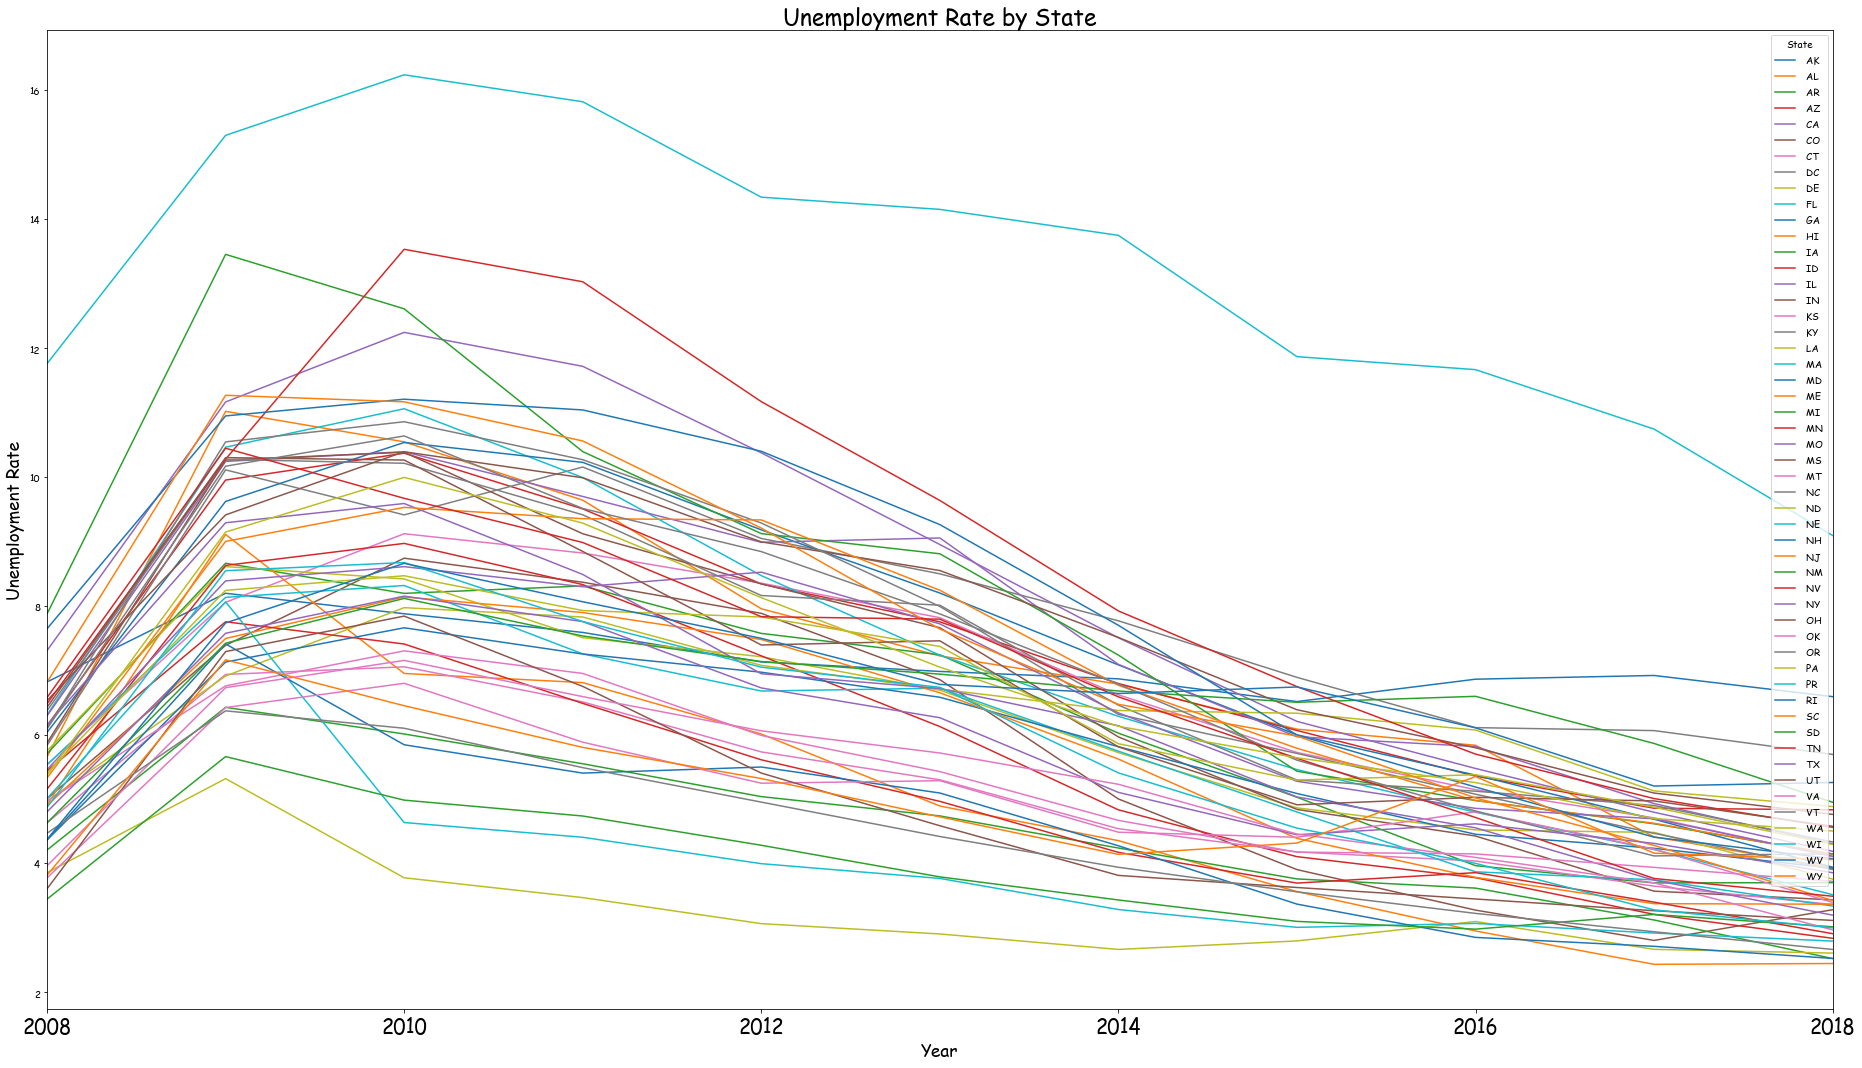

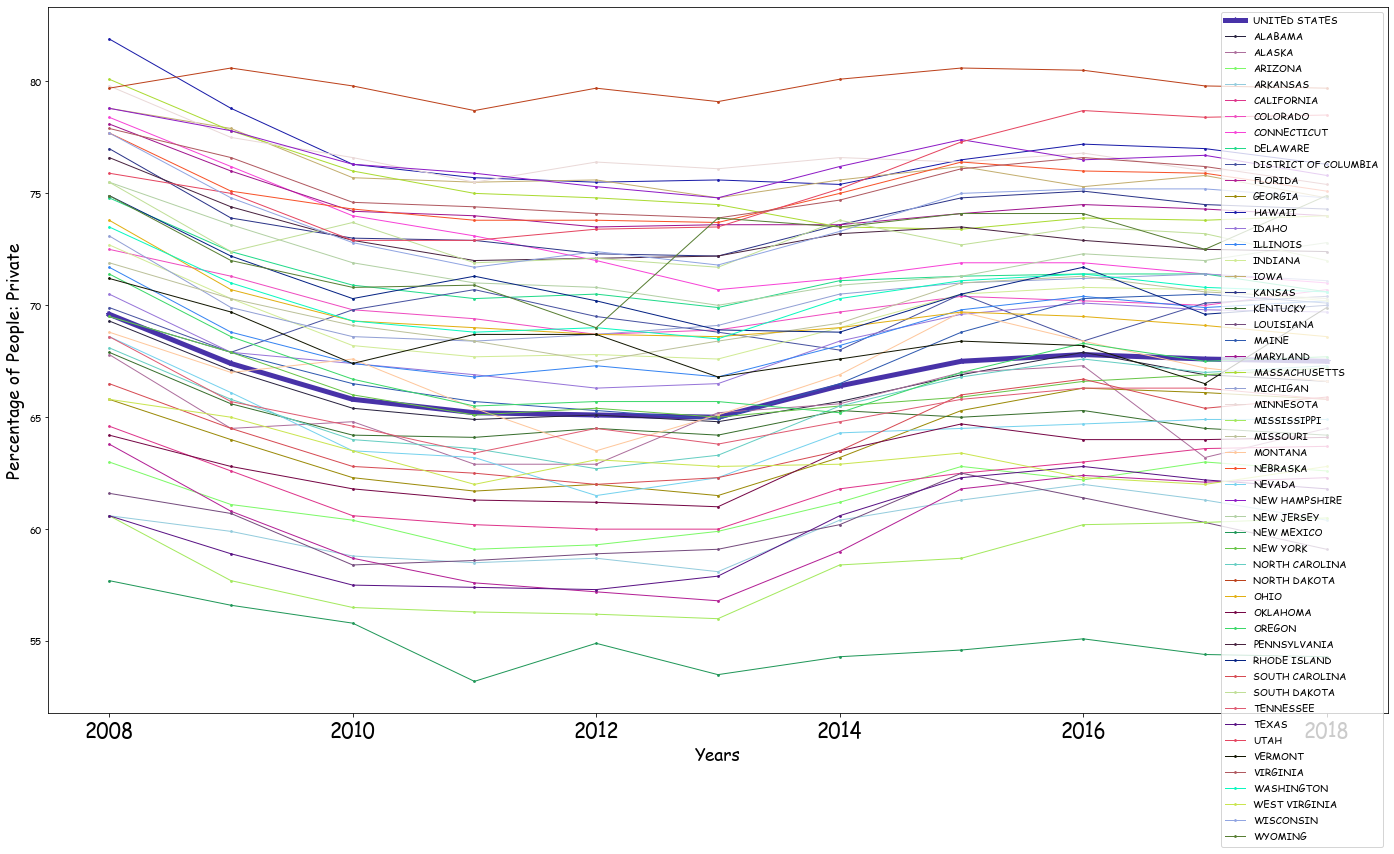

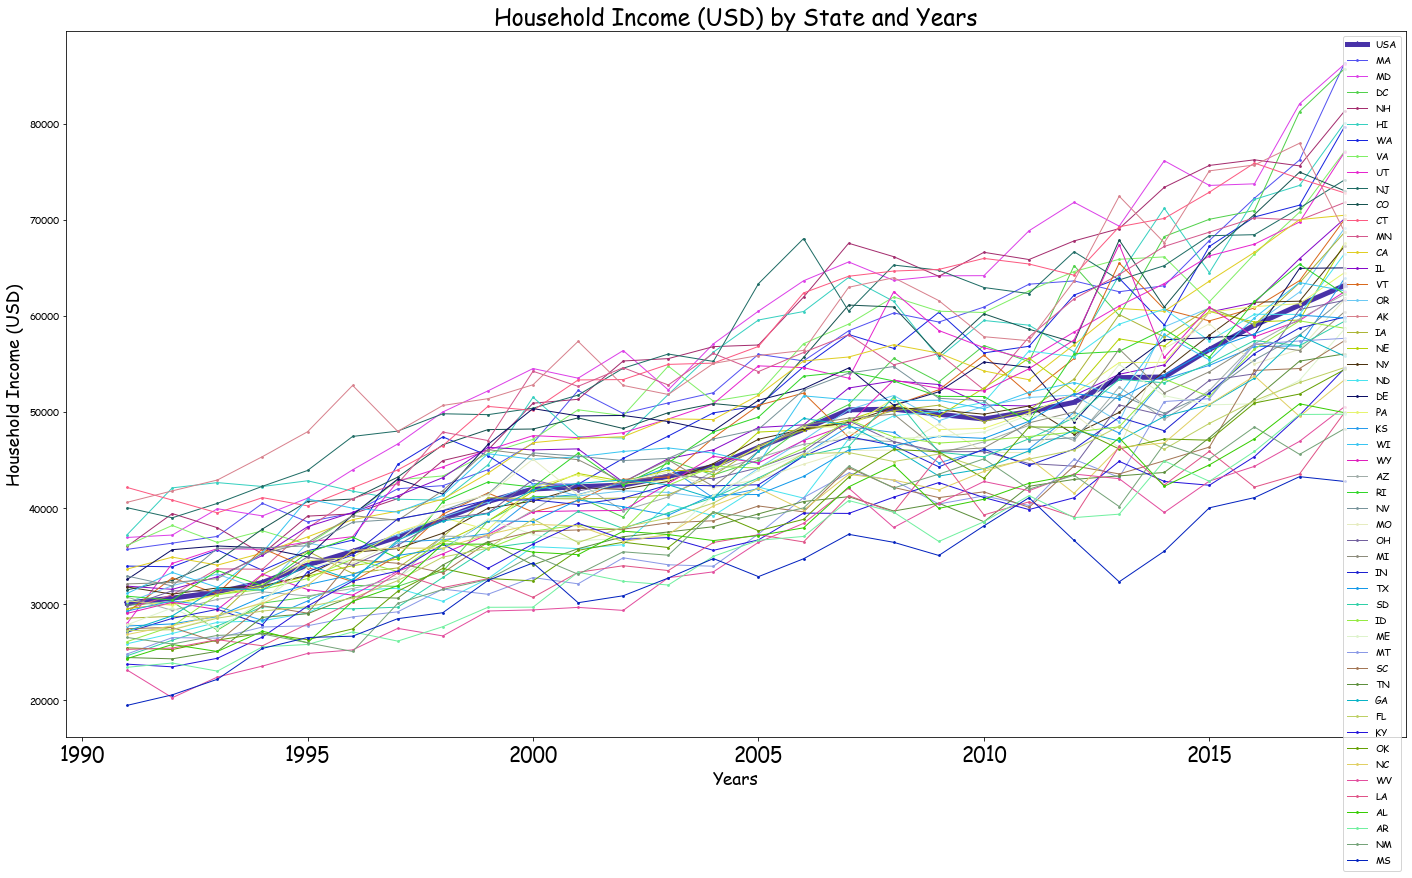

Healthcare coverage  growth rate & Unemployment  raw value Correlations:
AL  :  -0.5578785118728914
AK  :  -0.5078568817331439
AZ  :  -0.5545602745799143
AR  :  -0.20656176466257478
CA  :  -0.6905523774244152
CO  :  -0.6721279912419591
CT  :  -0.6689368795841828
DE  :  -0.5702329966806751
DC  :  -0.15032815116214732
FL  :  -0.6796575150501821
GA  :  -0.5236546126189067
HI  :  -0.7469514071399467
ID  :  -0.5797993982034092
IL  :  -0.607679760400952
IN  :  -0.6436790543401703
IA  :  -0.36256815133294185
KS  :  -0.5774764763037141
KY  :  -0.47432668323820903
LA  :  0.01559496007233269
ME  :  -0.6329256231577688
MD  :  -0.5983412040542273
MA  :  -0.8465267752740046
MI  :  -0.6737519709007599
MN  :  -0.614352354038049
MS  :  -0.5070781923372476
MO  :  -0.47911407067564854
MT  :  -0.29099634138627845
NE  :  -0.7541633149940865
NV  :  -0.5610096127434444
NH  :  -0.3512838379543684
NJ  :  -0.7589769539394332
NM  :  -0.2698101239875752
NY  :  -0.7309694572159828
NC  :  -0.6430886196222737
ND  :

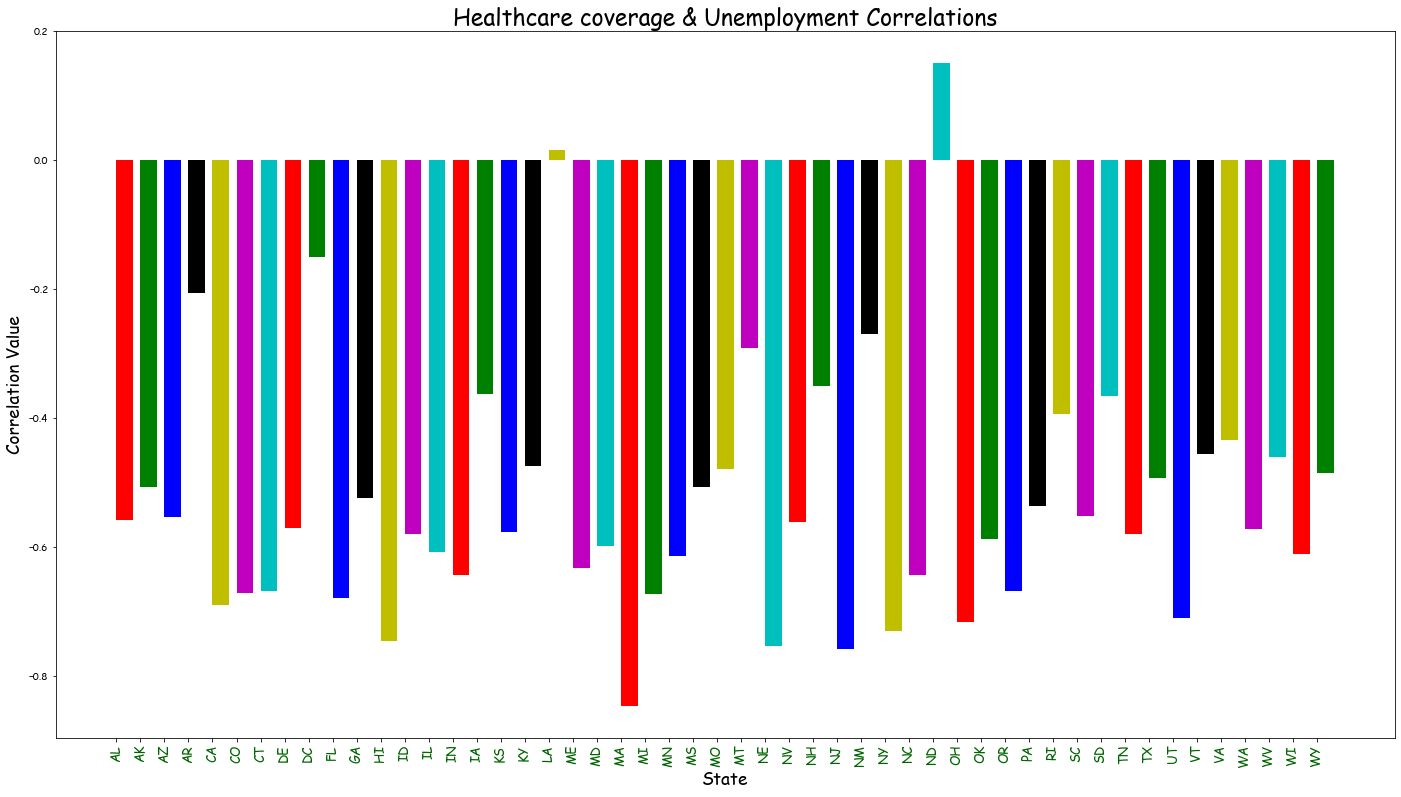

Unemployment  raw value & Healthcare coverage  growth rate Correlations:
US  :  0.20580083540104668
AL  :  -0.08806099285918847
AK  :  0.06107710916752366
AZ  :  0.2119519489949668
AR  :  0.1774521093133332
CA  :  0.017446463924075985
CO  :  -0.3134151609857577
CT  :  -0.18771034668205377
DE  :  0.09650028097124434
DC  :  0.11828202718454908
FL  :  0.2935568573531965
GA  :  0.11740341151544773
HI  :  -0.4004747762739418
ID  :  0.255268236183158
IL  :  0.54443419199744
IN  :  0.17053752258123234
IA  :  -0.2966366355206737
KS  :  0.1163202470398494
KY  :  -0.12540182237547204
LA  :  0.09033443517327397
ME  :  0.05298723828571756
MD  :  -0.17202017161282018
MA  :  -0.5155213828264129
MI  :  -0.154738291101631
MN  :  -0.3936482551079615
MS  :  0.31728564822497174
MO  :  -0.08067946362577648
MT  :  -0.04134687676336808
NE  :  -0.10991961393201022
NV  :  -0.10691895351359927
NH  :  -0.38839122798296405
NJ  :  0.0682464181948746
NM  :  0.3999684842112759
NY  :  0.03678474377361759
NC  :  0.11

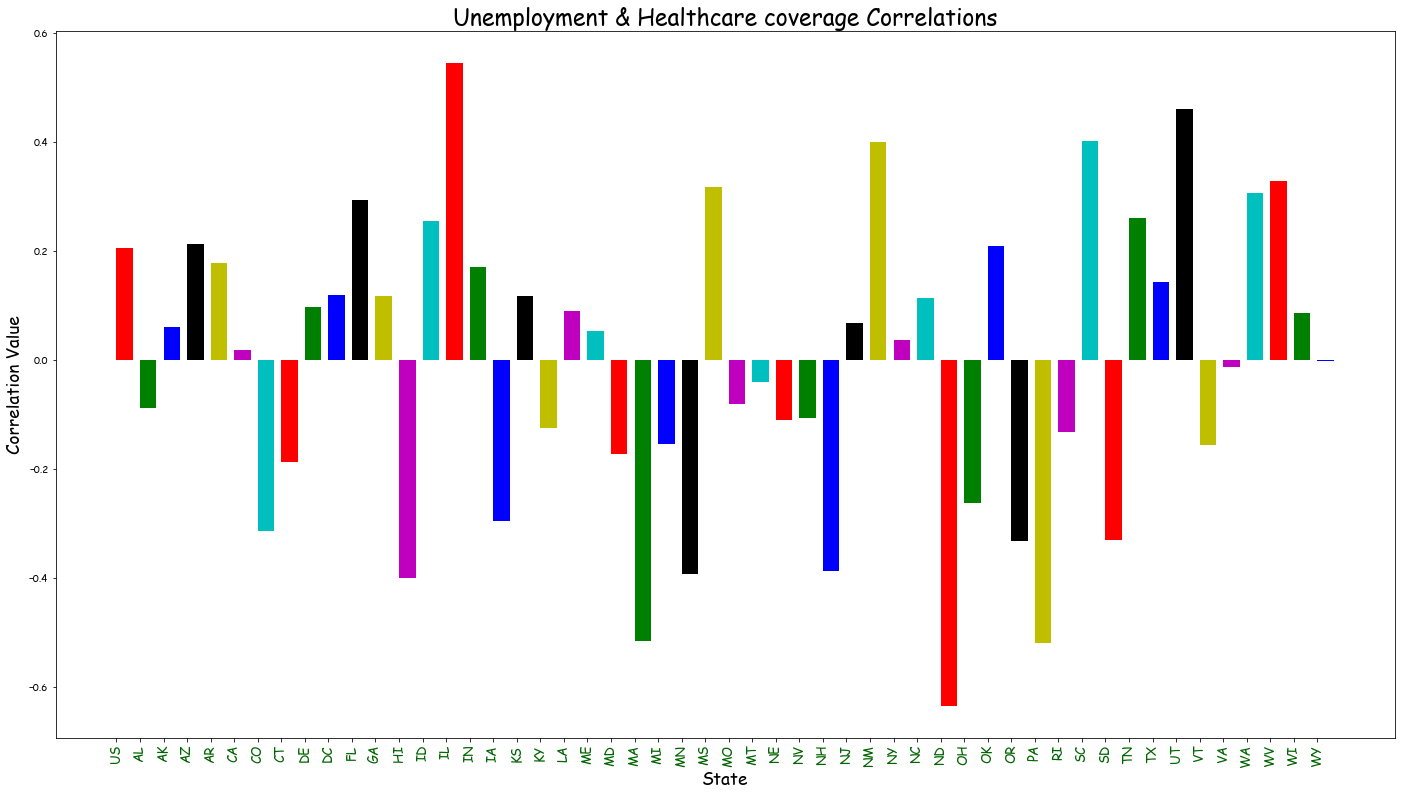

In [13]:


#TODO: A 3D-scatterplot to show the relations
# def 3d_scatter_plot_for_correlatons():

def main_test():
    print("Test function intact. File succesfully imported.")
    #TODO: read_unemployment_by_year() is bugged. Whenever the start_year is not 2008, data get out of whack.
    test_df_un = read_unemployment_by_year(2008, 2018, True)

    test_df_hc = read_health_care_coverage_by_year(2008, 2018, 'Private', True)

    test_df_hh_ic = read_household_income_by_year(1991, 2018, False)
    spawn_line_plot_from_dataframe(test_df_hh_ic, "Household Income (USD) by State and Years", "Years", "Household Income (USD)")

    #test_df_hh_ic = read_household_income_by_year_ver2(1991, 2018)

    test_df_cpi = read_cpi_by_year(2003, 2020)

    test_df_merged = merging_dataframes_on_years_plus_correlations(test_df_hc, test_df_un, "Healthcare coverage", "Unemployment", "First", True, True)
    test_df_merged = merging_dataframes_on_years_plus_correlations(test_df_hc, test_df_hh_ic, "Unemployment", "Healthcare coverage", "Second", True, True)

    spawn_choropleth_from_dataframe(test_df_hc, 2011, 'Private HC Coverage Year 2011', 'Jet', "% by state", False)

## Un-comment this line below to do a quick test of this file.
main_test()
#TODO: TravisCI test!!
#TODO: Optimization: Numba~ or Cython






